In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import random
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from scipy.special import expit
import torch
from torch import nn, optim
import torch.nn.functional as F
from datasets.datasets import get_MNIST_subset_dataloader
from typing import Optional
from scipy.optimize import linear_sum_assignment as linear_assignment

from sklearn.manifold import TSNE

cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ModuleNotFoundError: No module named 'torch'

## Mnist

In [ ]:
n_clusters = 10 # 10
batch_size = 256
data_per_pattern = 1000
latent_dim = 50
create_subset = True
capacity = 64
dataloader = get_MNIST_subset_dataloader(batch_size=batch_size, create_subset=create_subset, data_per_pattern=data_per_pattern)
N = len(dataloader) * batch_size

In [ ]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

#class MyUnflatten(torch.nn.Module):
    #def forward(self, x):
    #    batch_size = x.shape[0]
    #    return x.view(batch_size, capacity * 2, 7, 7)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder Model
        c = capacity # TODO wtf is that
        self.encoder_model = nn.Sequential(
            # out: c x 14 x 14
            nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1),
            #nn.ReLU(inplace=True),
            nn.Sigmoid(),
            
            # out: c x 7 x 7
            nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1),
            #nn.ReLU(inplace=True),
            nn.Sigmoid(),
            nn.Flatten(),
            
            nn.Linear(in_features=c*2*7*7, out_features=latent_dim)
        )
        
        # Clustering MLP
        self.cluster_MLP = nn.Sequential(
            #nn.Linear(latent_dim, h1, bias=True),
            #nn.ReLU(inplace=True),
            #nn.BatchNorm1d(h1),
            
            nn.Linear(latent_dim, n_clusters, bias=True),
            #nn.ReLU(inplace=True),
            nn.Sigmoid(),
            nn.BatchNorm1d(n_clusters)
        )
        
        # Decoder Model
        self.decoder_model = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=c*2*7*7),
            # unflatten batch of feature vectors to a batch of multi-channel feature maps
            nn.Unflatten(1, (capacity * 2, 7, 7)),
            nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
            #nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1),
            # last layer before output is tanh, since the images are normalized and 0-centered
            nn.Tanh(),
        )
    
    def forward(self, x):
        x = self.encoder_model(x)
        x = self.decoder_model(x)
        return x

    def forward_softMax(self, x):
        x = self.encoder_model(x)
        x = self.cluster_MLP(x)
        x = F.softmax(x, dim=1)
        return x
    
    def encoder(self, x):
        return self.encoder_model(x)
    
    def decoder(self, x):
        return self.decoder_model(x)

autoencoder = Autoencoder()
autoencoder = autoencoder.to(device)

### MLP ARCHITECTURE

In [2]:
h1 = 500 # 500
h2 = 500 # 500
h3 = 2000 # 2000
latent_dim = 10

class Autoencoder(nn.Module):
    def __init__(self, data_shape):
        super(Autoencoder, self).__init__()
        # Encoder Model
        self.encoder_model = nn.Sequential(
            nn.Linear(data_shape, h1, bias=True),
            #nn.ReLU(inplace=True),
            nn.Sigmoid(),
            nn.BatchNorm1d(h1),
            
            nn.Linear(h1, h2, bias=True),
            #nn.ReLU(inplace=True),
            nn.Sigmoid(),
            nn.BatchNorm1d(h2),
            
            nn.Linear(h2, h3, bias=True),
            #nn.ReLU(inplace=True),
            nn.Sigmoid(),
            nn.BatchNorm1d(h3),
            
            nn.Linear(h3, latent_dim, bias=True),
            #nn.ReLU(inplace=True),
            nn.Sigmoid(),
            nn.BatchNorm1d(latent_dim),
        )
        
        # Clustering MLP
        self.cluster_MLP = nn.Sequential(
            nn.Linear(latent_dim, n_clusters, bias=True),
            #nn.Sigmoid(),
            nn.BatchNorm1d(n_clusters)
        )
        
        # Decoder Model
        self.decoder_model = nn.Sequential(
            nn.Linear(latent_dim, h3, bias=True),
            #nn.ReLU(inplace=True),
            nn.Sigmoid(),
            nn.BatchNorm1d(h3),
            
            nn.Linear(h3, h2, bias=True),
            #nn.ReLU(inplace=True),
            nn.Sigmoid(),
            nn.BatchNorm1d(h2),
            
            nn.Linear(h2, h1, bias=True),
            #nn.ReLU(inplace=True),
            nn.Sigmoid(),
            nn.BatchNorm1d(h1),
            
            nn.Linear(h1, data_shape, bias=True),
            #nn.ReLU(inplace=True)
            nn.Sigmoid()
        )
    
        #self.cluster_MLP_params = self.cluster_MLP[0].parameters()
        #self.cluster_MLP_batchNorm = self.cluster_MLP[1].parameters()
        #self.cluster_MLP_params.append(nn.Parameter(torch.randn(2, 10)))
    
    def forward(self, x):
        x = self.encoder_model(x)
        x = self.decoder_model(x)
        return x

    def forward_softMax(self, x):
        x = self.encoder_model(x)
        x = self.cluster_MLP(x)
        x = F.softmax(x, dim=1)
        return x
    
    def encoder(self, x):
        x = self.encoder_model(x)
        return x
    
    def decoder(self, x):
        x = self.decoder_model(x)
        return x

data_shape = 784
autoencoder = Autoencoder(data_shape)
autoencoder = autoencoder.to(device)

NameError: name 'nn' is not defined

In [5]:
autoencoder.cluster_MLP_batchNorm

AttributeError: 'Autoencoder' object has no attribute 'cluster_MLP_batchNorm'

In [6]:
autoencoder.cluster_MLP[0].parameters()

<generator object Module.parameters at 0x7f866b217d80>

In [4]:
def soft_silhouette(X, soft_clustering, requires_distance_grad=False):
    # No grads at distances
    if requires_distance_grad: X = X.detach()
    distances = torch.cdist(X, X, p=2)
    alphas = torch.matmul(distances, soft_clustering).to(device)
    n_data, n_clusters = alphas.shape
    betas = torch.empty(alphas.shape).to(device)
    
    for i in range(n_data):
        for j in range(n_clusters):
            betas[i][j] = min([alphas[i][x] for x in range(alphas.shape[1]) if x!=j])
    
    # Calculate soft silhouette
    sc = torch.div(torch.sub(betas, alphas), torch.max(alphas, betas))
    s = torch.mean(torch.sum(torch.mul(soft_clustering, sc), dim=1))

    return s

def predictions(clusters):
    clusters = torch.argmax(clusters, dim=1)
    clusters = clusters.cpu().detach().numpy()
    return clusters

def transform_clusters_to_labels(clusters, labels):
    # Get the data clusters based on max neuron
    clusters = torch.argmax(clusters, dim=1)
    clusters = clusters.cpu().detach().numpy()

    # Find the cluster ids (labels)
    c_ids = np.unique(clusters)
    #labels = labels.cpu().data.numpy()

    # Dictionary to transform cluster label to real label
    dict_clusters_to_labels = dict()
    
    # For every cluster find the most frequent data label
    for c_id in c_ids:
        indexes_of_cluster_i = np.where(c_id == clusters)
        elements, frequency = np.unique(labels[indexes_of_cluster_i], return_counts=True)
        true_label_index = np.argmax(frequency)
        true_label = elements[true_label_index]
        dict_clusters_to_labels[c_id] = true_label

    # Change the cluster labels to real labels
    for i, element in enumerate(clusters):
        clusters[i] = dict_clusters_to_labels[element]

    return clusters

def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
    """
    Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
    determine reassignments.

    :param y_true: list of true cluster numbers, an integer array 0-indexed
    :param y_predicted: list of predicted cluster numbers, an integer array 0-indexed
    :param cluster_number: number of clusters, if None then calculated from input
    :return: reassignment dictionary, clustering accuracy
    """
    if cluster_number is None:
        # assume labels are 0-indexed
        cluster_number = (max(y_predicted.max(), y_true.max()) + 1)
    count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
    for i in range(y_predicted.size):
        count_matrix[y_predicted[i], y_true[i]] += 1

    row_ind, col_ind = linear_assignment(count_matrix.max() - count_matrix)
    reassignment = dict(zip(row_ind, col_ind))
    accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
    return reassignment, accuracy

In [5]:
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=1e-5)
mse = nn.MSELoss()

latent_data = np.zeros((N, latent_dim))

for epoch in range(50):
    total_rec_loss = 0
    for batch_index, (real_data, labels) in enumerate(dataloader):
        real_data = real_data.to(device)
        # TODO delete line
        real_data = torch.reshape(real_data, (real_data.shape[0], 784))
        
        reconstruction = autoencoder.forward(real_data)
        loss = mse(real_data, reconstruction)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_rec_loss += loss.item()
        
        # Selecting the nearest samples and save their priors
        code = autoencoder.encoder(real_data).to(device)
        lower = batch_index * batch_size
        upper = (batch_index + 1) * batch_size
        latent_data[lower:upper] = code.cpu().detach().numpy()
    
    print("Epoch: {} Rec: {:.4f} ".format(epoch, total_rec_loss))

Epoch: 0 Rec: 68.3002 
Epoch: 1 Rec: 49.0404 
Epoch: 2 Rec: 39.5776 
Epoch: 3 Rec: 37.5001 
Epoch: 4 Rec: 36.7174 
Epoch: 5 Rec: 35.9883 
Epoch: 6 Rec: 35.6564 
Epoch: 7 Rec: 35.4930 
Epoch: 8 Rec: 35.2104 
Epoch: 9 Rec: 35.0253 
Epoch: 10 Rec: 34.8735 
Epoch: 11 Rec: 34.7786 
Epoch: 12 Rec: 34.6986 
Epoch: 13 Rec: 34.6417 
Epoch: 14 Rec: 34.5949 
Epoch: 15 Rec: 34.5375 
Epoch: 16 Rec: 34.4804 
Epoch: 17 Rec: 34.4418 
Epoch: 18 Rec: 34.4169 
Epoch: 19 Rec: 34.3902 
Epoch: 20 Rec: 34.3786 
Epoch: 21 Rec: 34.3526 
Epoch: 22 Rec: 34.2803 
Epoch: 23 Rec: 34.2367 
Epoch: 24 Rec: 34.2099 
Epoch: 25 Rec: 34.1994 
Epoch: 26 Rec: 34.1932 
Epoch: 27 Rec: 34.1719 
Epoch: 28 Rec: 34.1432 
Epoch: 29 Rec: 34.1171 
Epoch: 30 Rec: 34.1003 
Epoch: 31 Rec: 34.1066 
Epoch: 32 Rec: 34.1054 
Epoch: 33 Rec: 34.0759 
Epoch: 34 Rec: 34.0382 
Epoch: 35 Rec: 34.0119 
Epoch: 36 Rec: 34.0069 
Epoch: 37 Rec: 34.0311 
Epoch: 38 Rec: 34.0183 
Epoch: 39 Rec: 33.9836 
Epoch: 40 Rec: 33.9569 
Epoch: 41 Rec: 33.9493 
Ep

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters)
kmeans = kmeans.fit(latent_data)
kmeans_centers_init = kmeans.cluster_centers_

In [7]:
#kmeans_centers_init.shape
autoencoder.cluster_MLP[0].weight = nn.Parameter(torch.tensor(kmeans_centers_init, dtype=torch.float32))

In [28]:
autoencoder.decoder_model.load_state_dict(torch.load('./Models/decoder_model.pth'))
autoencoder.encoder_model.load_state_dict(torch.load('./Models/encoder_model.pth'))
#autoencoder.cluster_MLP.load_state_dict(torch.load('./Models/cluster_MLP.pth'))

<All keys matched successfully>

In [27]:
weights = autoencoder.cluster_MLP[0].weight
prev_weights = torch.load('./Models/cluster_MLP.pth')['0.weight']

In [30]:
#torch.cdist(weights, prev_weights)
weights, prev_weights

(Parameter containing:
 tensor([[ 0.0622, -0.2617, -0.9743, -1.1115, -1.0057, -1.0468, -1.1214, -0.9170,
           0.0773, -0.9461],
         [-0.4524, -0.2710,  0.8739,  0.7380,  0.9282,  0.8404,  0.8668,  0.9301,
          -0.6355,  0.9547],
         [ 1.5832,  1.5727, -1.0408, -1.1682, -1.0589, -1.0925, -1.1756, -0.9956,
           1.7606, -1.0021]], requires_grad=True),
 tensor([[ 0.0413, -0.0485,  0.2355,  0.1991,  0.2899,  0.3390,  0.3186,  0.2634,
           0.0051,  0.2758],
         [-0.5374,  0.3122, -0.9894, -0.8868, -1.1080, -1.1752, -1.2041, -1.0945,
           0.0776, -1.0738]]))

In [ ]:
lamda = 1
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=1e-5)
mse = nn.MSELoss()

latent_data = np.zeros((N, latent_dim))
real_labels = np.zeros((N), dtype=np.int32)
predicted_labels = np.zeros((N), dtype=np.int32)

for epoch in range(20):
    sum_rec_loss = 0
    sum_soft_sihouette = 0
    for batch_index, (real_data, labels) in enumerate(dataloader):
        real_data = real_data.to(device)
        # TODO delete line
        real_data = torch.reshape(real_data, (real_data.shape[0], 784))
        reconstruction = autoencoder.forward(real_data)
        soft_clustering = autoencoder.forward_softMax(real_data).to(device)
        code = autoencoder.encoder(real_data).to(device)
        s = soft_silhouette(code, soft_clustering, requires_distance_grad=True)
    
        rec = mse(reconstruction, real_data)
        loss = 1 - s + lamda * rec
        
        sum_rec_loss += rec.item()
        sum_soft_sihouette += s.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        # Selecting the nearest samples and save their priors
        lower = batch_index * batch_size
        upper = (batch_index + 1) * batch_size
        latent_data[lower:upper] = code.cpu().detach().numpy()
        real_labels[lower:upper] = labels.cpu().data.numpy()
        predicted_labels[lower:upper] = predictions(soft_clustering) # transform_clusters_to_labels(soft_clustering, labels)
        
        # TODO delete lines
        if epoch == 100000 and batch_index == 0: #% 100 == 0 and epoch > 0:
            with torch.no_grad():
                print("HI")
                #n_clusters += 1
                kmeans = KMeans(n_clusters=n_clusters)
                kmeans = kmeans.fit(latent_data)
                kmeans_centers_init = kmeans.cluster_centers_

                #autoencoder.cluster_MLP[0].out_features += 1
                #autoencoder.cluster_MLP[0].weight = nn.Parameter(torch.tensor(kmeans_centers_init, dtype=torch.float32))
                #autoencoder.cluster_MLP_batchNorm.num_features += 1
                
                autoencoder.cluster_MLP[0].append(nn.Parameter(torch.randn(1, 10)))
                optimizer = optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=1e-5)

                #new_param = nn.Parameter(torch.randn(1, 10))
                #autoencoder.cluster_MLP_params.append(new_param)
    
    cl_accuracy = cluster_accuracy(real_labels, predicted_labels)[1]
    gr_accuracy = 0 #accuracy_score(transform_clusters_to_labels(soft_clustering, real_labels), real_labels)
    nmi = normalized_mutual_info_score(real_labels, predicted_labels)
    total_loss = sum_rec_loss + sum_soft_sihouette
    print("Epoch: {} L: {:.4f} Rec: {:.4f} Soft SIL: {:.2f} CL_ACC: {:.2f} GR_ACC: {:.2f} NMI: {:.2f} ".format(epoch, total_loss, sum_rec_loss, sum_soft_sihouette, cl_accuracy, gr_accuracy, nmi))
    
    # TODO delete lines
    torch.save(autoencoder.decoder_model.state_dict(), './Models/decoder_model.pth')
    torch.save(autoencoder.encoder_model.state_dict(), './Models/encoder_model.pth')
    #torch.save(autoencoder.cluster_MLP.state_dict(), './Models/cluster_MLP.pth')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9984 samples in 0.009s...


/home/giorgos/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/giorgos/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 9984 samples in 0.410s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9984
[t-SNE] Computed conditional probabilities for sample 2000 / 9984
[t-SNE] Computed conditional probabilities for sample 3000 / 9984
[t-SNE] Computed conditional probabilities for sample 4000 / 9984
[t-SNE] Computed conditional probabilities for sample 5000 / 9984
[t-SNE] Computed conditional probabilities for sample 6000 / 9984
[t-SNE] Computed conditional probabilities for sample 7000 / 9984
[t-SNE] Computed conditional probabilities for sample 8000 / 9984
[t-SNE] Computed conditional probabilities for sample 9000 / 9984
[t-SNE] Computed conditional probabilities for sample 9984 / 9984
[t-SNE] Mean sigma: 0.083200
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.363586
[t-SNE] KL divergence after 300 iterations: 2.427352


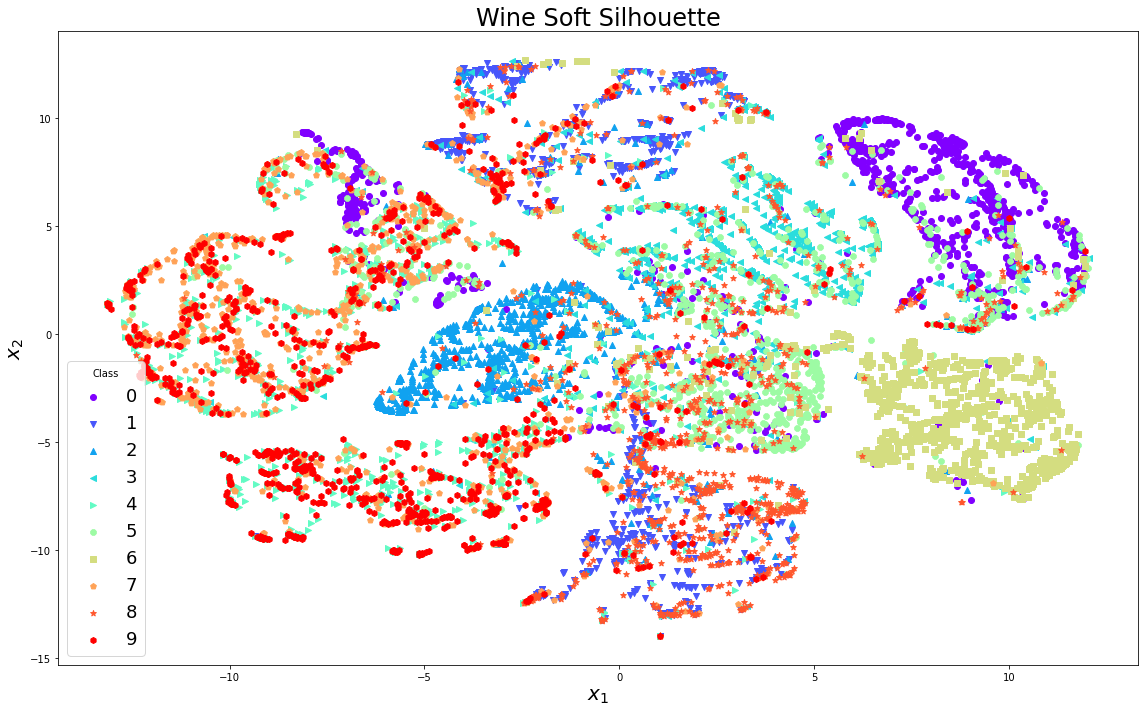

In [10]:
# Cluster with TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_enc = tsne.fit_transform(latent_data)
#tsne_enc = tsne.fit_transform(real_data)

# Color and marker for each true class
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
markers = matplotlib.markers.MarkerStyle.filled_markers

# Save TSNE figure to file
fig, ax = plt.subplots(figsize=(16, 10))
for iclass in range(0, n_clusters):
    # Get indices for each class
    idxs = real_labels==iclass
    # Scatter those points in tsne dims
    ax.scatter(tsne_enc[idxs, 0], tsne_enc[idxs, 1],
               marker=markers[iclass], c=colors[iclass].reshape(1,-1),
               edgecolor=None, label=r'$%i$'%iclass)
    
figname="Wine Soft Silhouette"
ax.set_title(figname, fontsize=24)
ax.set_xlabel("$x_{1}$", fontsize=20)
ax.set_ylabel("$x_{2}$", fontsize=20)
plt.legend(title="Class", loc='best', numpoints=1, fontsize=18)
plt.tight_layout()
plt.show()
#fig.savefig(figname, facecolor='w')

In [25]:
autoencoder.cluster_MLP[0].out_features

3

In [26]:
autoencoder

Autoencoder(
  (encoder_model): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=500, out_features=2000, bias=True)
    (7): ReLU(inplace=True)
    (8): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=2000, out_features=10, bias=True)
    (10): ReLU(inplace=True)
    (11): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cluster_MLP): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder_model): Sequential(
    (0): Linear(in

In [27]:
 #.BatchNorm1d #= nn.Parameter(torch.tensor(kmeans_centers_init, dtype=torch.float32))


In [28]:
autoencoder.cluster_MLP[0]

Linear(in_features=10, out_features=3, bias=True)

In [30]:
autoencoder.cluster_MLP[0].weight.shape

torch.Size([2, 10])